# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [132]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Importing dependencies and define helper functions

In [134]:
env = gym.make("CartPole-v1")

## Tutorial: Loading CartPole environment

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [135]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [136]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [137]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.02929131  0.02550648  0.02277301 -0.0303246 ]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [138]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02980144 -0.16993453  0.02216652  0.26945558]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [139]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 8.0


## Task 1: Development of an RL agent

Now we will try to create a Q learning model

First, we set our Q(s,a) state-action pairs into a discrete number instead of a continuous range as given in the observation_state. 

This prevents the number of state-action pairs from being too large. Let's use 40 as the number of states.

In [140]:
state_space = 4 # number of states
action_space = 2 # number of possible actions
bin_size = 40

def Qtable(state_space, action_space, bin_size):
    
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

#this function splits the continuous observation space into discrete chunks of size = bin_size
#it also returns the state-action pairs in the form of an array

def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

#this function takes in the obversation state array and the bin array
#returns a tuple showing the location of the cart pole in discrete form
#closer to 0 = leaning left
#closer to len(bin[0]) = leaning right

In [141]:
q_table, bins = Qtable(4,2,40)
observation = env.reset()
Discrete(observation, bins)

(19, 19, 21, 19)

Now, we will create our Q learning agent.

In [142]:
def q_learning_sample(q_table, bins, learning_rate = 0.5, episodes = 1, gamma = 0.90, timestep = 100):
    episode_results = []
    epsilon = 1
    learning_rate = 1
    cumulative_reward = 0

    for episode in range(1,episodes+1):
        current_state = Discrete(env.reset(),bins)
        
        episode_rewards = 0
        done = False

        if (epsilon > 0.05):
            epsilon *= 0.999
       
        while not done: 
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
            print('Observation: ',current_state)
            print('Action taken: ',action)
            observation, reward, done, info = env.step(action)

            next_state = Discrete(observation,bins)
            episode_rewards += reward
            
            if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state + (action,)]
                new_q = (1 - learning_rate) * current_q + learning_rate * (reward + gamma * max_future_q)
                q_table[current_state + (action,)] = new_q
            current_state = next_state
        else:
            cumulative_reward += episode_rewards
    

Let's run the agent once to test its correctness

In [143]:
q_table, bins = Qtable(4,2,40)

q_learning_sample(q_table, bins, learning_rate = 0.05, episodes = 1, gamma = 0.95, timestep = 100)

Observation:  (19, 19, 19, 19)
Action taken:  0
Observation:  (19, 18, 19, 20)
Action taken:  1
Observation:  (19, 19, 20, 19)
Action taken:  1
Observation:  (19, 20, 20, 17)
Action taken:  1
Observation:  (19, 21, 19, 16)
Action taken:  0
Observation:  (19, 20, 19, 17)
Action taken:  0
Observation:  (19, 19, 18, 19)
Action taken:  1
Observation:  (19, 20, 18, 17)
Action taken:  0
Observation:  (19, 19, 18, 19)
Action taken:  0
Observation:  (19, 18, 18, 20)
Action taken:  0
Observation:  (19, 17, 18, 22)
Action taken:  1
Observation:  (19, 18, 19, 20)
Action taken:  0
Observation:  (19, 17, 19, 22)
Action taken:  0
Observation:  (19, 16, 19, 23)
Action taken:  1
Observation:  (19, 17, 20, 22)
Action taken:  0
Observation:  (19, 16, 21, 23)
Action taken:  1
Observation:  (19, 17, 21, 22)
Action taken:  0
Observation:  (19, 16, 22, 23)
Action taken:  0
Observation:  (19, 15, 23, 25)
Action taken:  1
Observation:  (19, 16, 24, 23)
Action taken:  1
Observation:  (19, 17, 25, 22)
Action ta

Let's develop our training agent, and add functionality to plot a graph of average rewards

In [147]:
'''
learning rate is the probability of the agent using new Q-values or sticking to previous Q-values
if learning rate = 0, then the agent will never learn, if learning rate = 1, the agent learns quickly

epsilon value is the trade-off between choosing the best (greedy) option or choosing a random option
choosing a random option means that it ignores its learning and chooses a random option
it may lead to a suboptimal solution but it ensures that all bases are covered

gamma is the discount constant, where a higher gamma means that earlier rewards are prioritised 

we will start with epsilon value = 1, and decay it throughout the training process. as the q table
is initialised to 0 at the start, it is better to start at higher epsilon values
to allow the agent to explore the different states randomly, and once the q table is continually updated,
explore randomly less and utilise the q table more. 
'''
#this function runs the q_learning algorithm for n episodes
def q_learning_training(q_table, bins, learning_rate = 0.5, episodes = 5000, gamma = 0.90, timestep = 100):
    # initialise an array to store our rewards each episode to plot graph later on
    episode_results = []
    epsilon = 1
    learning_rate = 1
    cumulative_reward = 0

    for episode in range(1,episodes+1):
        # discretise the intitial observation env.reset()
        current_state = Discrete(env.reset(),bins)
        
        # initialise rewards for current episode
        episode_rewards = 0
        done = False

        # decay epsilon values
        if (epsilon > 0.05):
            epsilon *= 0.999
       

        # keep running the agent until the pole falls off or max reward of 500 is reached
        while not done: 
            # choose random action or highest q value based on epsilon
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])

            # agent moves to next state based on the above action taken
            observation, reward, done, info = env.step(action)

            # discretise new state
            next_state = Discrete(observation,bins)
            episode_rewards += reward
            
            # update q table based on the Bellman equation
            if not done:
                # obtain the max q value of the next state between the 2 actions
                max_future_q = np.max(q_table[next_state])

                # obtain the q value of the current state + action taken
                current_q = q_table[current_state + (action,)]

                # update the new q value of the current state based on Bellman equation
                new_q = (1 - learning_rate) * current_q + learning_rate * (reward + gamma * max_future_q)

                # update q table with the new q value
                q_table[current_state + (action,)] = new_q

            # set current state to next state
            current_state = next_state
            
        # after episode has ended
        else:
            # add episode rewards into cumulative rewards for calculation purposes
            cumulative_reward += episode_rewards
            
            # if episode_rewards > 195: print('Solved in episode:', episode)

        #print(episode_rewards)

        # add episode results into reward array
        episode_results.append(episode_rewards)
        '''
        prints the average reward obtained in intervals of timestep
        the difference in average reward between intervals is the average reward obtained during the episodes in that interval
        example: if the difference is 500, then every episode received a reward of 500
        '''
        if episode % timestep == 0: 
            print('Episode : {} | Reward -> {} | Epsilon : {}'.format(episode, cumulative_reward/timestep, epsilon))
    # plot average rewards in graph form
    plt.plot(episode_results)
    plt.title('Cumulative reward for each episode')
    plt.ylabel('Cumulative reward')
    plt.xlabel('episode')
    plt.show()

    avg = sum(episode_results)/len(episode_results)
    print("Average cumulative reward:", avg)
    print("Is my agent good enough?", avg > 195)

    #returns epsilon values to be used for the test set
    return epsilon

In [192]:
def q_learning_test(q_table, bins, epsilon, learning_rate = 0.5, episodes = 5000, gamma = 0.90, timestep = 100):
    # initialise an array to store our rewards each episode to plot graph later on
    episode_results = []
    cumulative_reward = 0

    for episode in range(1,episodes+1):
        # discretise the intitial observation env.reset()
        current_state = Discrete(env.reset(),bins)
        
        # initialise rewards for current episode
        episode_rewards = 0
        done = False
        
        # keep running the agent until the pole falls off or max reward of 500 is reached
        while not done: 
            # choose random action or highest q value based on epsilon
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])

            # agent moves to next state based on the above action taken
            observation, reward, done, info = env.step(action)

            # discretise new state
            next_state = Discrete(observation,bins)
            episode_rewards += reward
            
            # update q table based on the Bellman equation
            if not done:
                # obtain the max q value of the next state between the 2 actions
                max_future_q = np.max(q_table[next_state])

                # obtain the q value of the current state + action taken
                current_q = q_table[current_state + (action,)]

                # update the new q value of the current state based on Bellman equation
                new_q = (1 - learning_rate) * current_q + learning_rate * (reward + gamma * max_future_q)

                # update q table with the new q value
                q_table[current_state + (action,)] = new_q

            # set current state to next state
            current_state = next_state
            
        # after episode has ended
        else:
            # add episode rewards into cumulative rewards for calculation purposes
            cumulative_reward += episode_rewards

            # if episode_rewards > 195: print('Solved in episode:', episode)

        #print(episode_rewards)

        # add episode results into reward array
        episode_results.append(episode_rewards)
        '''
        prints the average reward obtained in intervals of timestep
        the difference in average reward between intervals is the average reward obtained during the episodes in that interval
        example: if the difference is 500, then every episode received a reward of 500
        '''
        if episode % timestep == 0: 
            print('Episode : {} | Reward -> {}'.format(episode, cumulative_reward/timestep))
    # plot average rewards in graph form
    plt.plot(episode_results)
    plt.title('Cumulative reward for each episode')
    plt.ylabel('Cumulative reward')
    plt.xlabel('episode')
    plt.show()

    avg = sum(episode_results)/len(episode_results)
    print("Average cumulative reward:", avg)
    print("Is my agent good enough?", avg > 195)

Then, we will train our model with 100000 training episodes. 

Episode : 100 | Reward -> 22.14 | Epsilon : 0.9047921471137096
Episode : 200 | Reward -> 50.92 | Epsilon : 0.818648829478636
Episode : 300 | Reward -> 79.54 | Epsilon : 0.7407070321560997
Episode : 400 | Reward -> 108.57 | Epsilon : 0.6701859060067403
Episode : 500 | Reward -> 144.15 | Epsilon : 0.6063789448611848
Episode : 600 | Reward -> 179.1 | Epsilon : 0.5486469074854965
Episode : 700 | Reward -> 216.49 | Epsilon : 0.4964114134310989
Episode : 800 | Reward -> 255.74 | Epsilon : 0.4491491486100748
Episode : 900 | Reward -> 299.1 | Epsilon : 0.4063866225452039
Episode : 1000 | Reward -> 341.62 | Epsilon : 0.3676954247709635
Episode : 1100 | Reward -> 378.09 | Epsilon : 0.33268793286240766
Episode : 1200 | Reward -> 416.49 | Epsilon : 0.3010134290933992
Episode : 1300 | Reward -> 452.23 | Epsilon : 0.27235458681947705
Episode : 1400 | Reward -> 495.55 | Epsilon : 0.24642429138466176
Episode : 1500 | Reward -> 530.19 | Epsilon : 0.22296276370290227
Episode : 1600 | Reward -> 569.74 | 

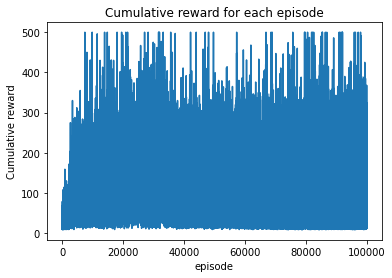

Average cumulative reward: 119.48736
Is my agent good enough? False


In [178]:
q_table, bins = Qtable(4,2,40)

trained_epsilon = q_learning_training(q_table, bins, learning_rate = 0.05, episodes = 100000, gamma = 0.95, timestep = 100)

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

100 test episodes with Q-learned model. 

Episode : 100 | Reward -> 254.27


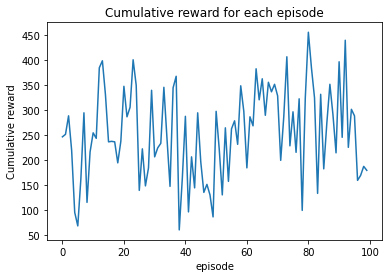

Average cumulative reward: 254.27
Is my agent good enough? True


In [194]:
q_learning_test(q_table, bins, trained_epsilon, learning_rate = 0.05, episodes = 100, gamma = 0.95, timestep = 100)

## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

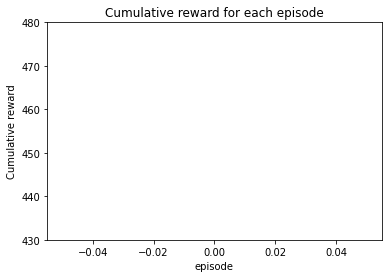

Average cumulative reward: 455.0
Is my agent good enough? True


In [197]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    q_learning_test(q_table, bins, trained_epsilon, learning_rate = 0.05, episodes = 1, gamma = 0.95, timestep = 100)
    if done: 
      break;    
env.close()
show_video()

References:
https://ai.stackexchange.com/questions/18283/is-there-an-advantage-in-decaying-epsilon-during-q-learning

